<a href="https://colab.research.google.com/github/jabarragann/PytorchTutorialsJuanAntonio/blob/master/EEG_Classification2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os 
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter
import shutil
from itertools import product

def butter_bandpass(lowcut, highcut, fs, order=7):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=7):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def preprocessData(dataset=1, trial=3):
    os.chdir("/content/RunTimeDir")


    path = "Data/D{:d}/raw/S1_T{:d}_Epoc.txt".format(dataset,trial)

    data = pd.read_csv(path, sep=' ')

    data.shape
    headers = list(data.columns.values)
#     print(headers)

    #Get Epoc Data
    computerStamps = data['COMPUTER_TIME'].values
    epocSlice = data[['AF3', 'F7', 'F3', 'FC5', 'T7',
                      'P7', 'O1', 'O2', 'P8', 'T8',
                      'FC6', 'F4', 'F8', 'AF4']].values

    ##################################################################################
    #Normalize data electrode-wize
    meanVector = np.mean(epocSlice,axis=0).reshape(-1, 14)
    stdVector = np.std(epocSlice,axis=0).reshape(-1, 14)
    epocSlice = (epocSlice - meanVector) / (2*stdVector)
    
    #Filter Data
    epocFiltered = np.zeros(epocSlice.shape)

    lowCut  = 0.5
    highCut = 38
    for i in range(14):
        temp = butter_bandpass_filter(epocSlice[:, i], lowCut, highCut, 128, order=7)
        epocFiltered[:, i] = temp
        
     #Clip signals that are over abs(400)
    epocFiltered = np.clip(epocFiltered, -5, 5)
    #################################################################################
    
    
    #Remove first 30 seconds of samples from the beginning of the data.
    n = 3800
    finalArrayEpoc = np.ones((epocFiltered.shape[0] - n , epocFiltered.shape[1]+4)) * -10
    finalArrayEpoc[:,:14] = epocFiltered[n:, :]
    finalArrayEpoc[:,14] = computerStamps[n:]
    
#     print(epocFiltered[700:,:].shape)
#     print(epocFiltered[700:,:].min())
#     print(epocFiltered[700:,:].max())
    
#     print(finalArrayEpoc.shape)
#     print(finalArrayEpoc[:,:14].min())
#     print(finalArrayEpoc[:,:14].max())

    #### EEG PRE PROCESSING ####
    
    secondaryTaskArr = pd.read_csv("./Data/D{:d}/raw/S1_T{:d}_Timestamps.txt".format(dataset, trial),
                                      sep=' ', skiprows=[0,1,2,3]).values
    fiveSecondStampsSrc ="./Data/D{:d}/raw/S1_T{:d}_TimestampEvery5Seconds.txt".format(dataset,trial)
    fiveSecondStampsDst ="./Data/D{:d}/preprocessed/S1_T{:d}_TimestampEvery5Seconds.txt".format(dataset,trial)

    windowStampsArr = pd.read_csv(fiveSecondStampsSrc, sep=' ').values

    #Copy 5seconds timestamp to preprocessed file
    shutil.copy(fiveSecondStampsSrc, fiveSecondStampsDst)

    #Add Secondary task timestamps to EEG data
    idx = 0
    for i in range(secondaryTaskArr.shape[0]):
        timestamp = secondaryTaskArr[i,0]
        while timestamp > finalArrayEpoc[idx,14]:
            idx += 1
            if idx == finalArrayEpoc.shape[0]:
                break

        if idx == finalArrayEpoc.shape[0]:
            break
        if idx < finalArrayEpoc.shape[0]:
            finalArrayEpoc[idx, -3] = timestamp

    #Add 5 Seconds Windows timestamps to EEG data
    idx = 0
    for i in range(windowStampsArr.shape[0]):
        timestamp = windowStampsArr[i,0]
        while timestamp > finalArrayEpoc[idx,14]:
            idx += 1
            if idx == finalArrayEpoc.shape[0]:
                break

        if idx == finalArrayEpoc.shape[0]:
            break
        if idx < finalArrayEpoc.shape[0]:
            finalArrayEpoc[idx, -2] = timestamp

    # Add Label
    count = 0
    for idx in range(finalArrayEpoc.shape[0]):
        time = finalArrayEpoc[idx, 14]

        if count == secondaryTaskArr.shape[0] -1:
            finalArrayEpoc[idx, -1] = 1 if secondaryTaskArr[count, 1] is True else 0
        else:
            if time > secondaryTaskArr[count,0] and  time < secondaryTaskArr[count+1,0]:
                finalArrayEpoc[idx, -1] = 1 if secondaryTaskArr[count, 1] is True else 0
            elif time > secondaryTaskArr[count+1, 0]:
                finalArrayEpoc[idx, -1] = 1 if secondaryTaskArr[count + 1, 1] is True else 0
                count += 1

    # Write Final File
    #EEG File
    with open('./Data/D{:d}/preprocessed/S1_T{:d}_fusion_epoc.txt'.format(dataset, trial),'w') as fout:
        fout.write("AF3 F7 F3 FC5 T7 P7 O1 O2 P8 T8 FC6 F4 F8 AF4 COMPUTER_TIME SECONDARY_TASK 5_SECOND_WINDOW LABEL\n")
        for i in range(finalArrayEpoc.shape[0]):
            formattedData = " ".join(["{:.8f}".format(d) for d in finalArrayEpoc[i]])
            fout.write(formattedData+'\n')
        
        
# print(epocFiltered.shape[1])
# print(finalArrayEpoc[:5,:])
# print(finalArrayEpoc.shape)


########            
# main##
########

d1 = product([1],[3,4,5,6,7])
d2 = product([2],[2,4,5,6,7])
d3 = product([3],[3,4,5,6,7])
d4 = product([4],[1,2,3,4,5])

completeData = [d1,d2, d3,d4]
#completeData = [d3]

for idx, iterT in enumerate(completeData):
    print("Preprocessing dataset {:d}".format(idx + 1))
    for dataset, trial in iterT:
        preprocessData(trial=trial, dataset=dataset)


Preprocessing dataset 1
Preprocessing dataset 2
Preprocessing dataset 3
Preprocessing dataset 4


(45753,)
(49618,)
(49612,)
(49624,)
(49566,)


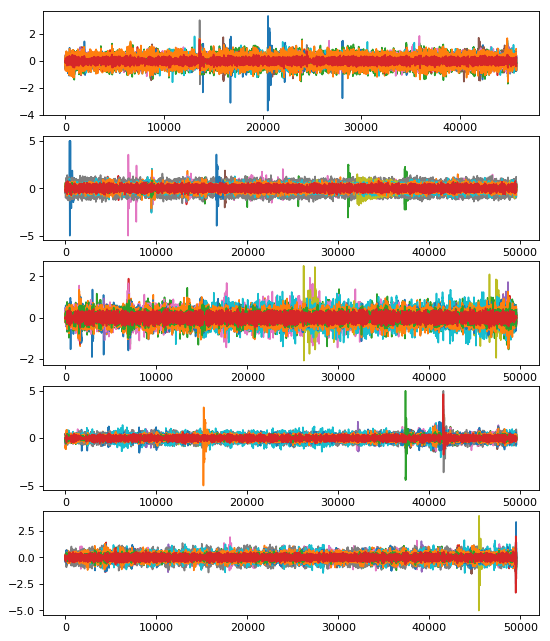

In [3]:
import matplotlib.pyplot as plt

d1 = product([1],[3,4,5,6,7])
d2 = product([2],[2,4,5,6,7])
d3 = product([3],[3,4,5,6,7])
d4 = product([4],[1,2,3,4,5])

fig, axes = plt.subplots(5,1,figsize=(8, 10), dpi= 80)

for idx, pack in enumerate(d3):
    
    dataset, trial = pack
    path = "Data/D{:d}/preprocessed/S1_T{:d}_fusion_epoc.txt".format(dataset,trial)
    data = pd.read_csv(path, sep=' ')
    epocSlice = data[['AF3', 'F7', 'F3', 'FC5', 'T7',
                      'P7', 'O1', 'O2', 'P8', 'T8',
                      'FC6', 'F4', 'F8', 'AF4']].values

    print(epocSlice[:,0].shape)
    for i in range(14):
        axes[idx].plot(epocSlice[:,i])


# #Test 2
# dataset= 3
# trial = 3
# path = "Data/D{:d}/preprocessed/S1_T{:d}_fusion_epoc.txt".format(dataset,trial)

# data = pd.read_csv(path, sep=' ')

# epocSlice = data[['AF3', 'F7', 'F3', 'FC5', 'T7',
#                   'P7', 'O1', 'O2', 'P8', 'T8',
#                   'FC6', 'F4', 'F8', 'AF4']].values


# print(epocSlice[:,:].min())
# print(epocSlice[:,:].max())

# for i in range(14):
#     axes[1].plot(epocSlice[:,i])





In [16]:
import pandas as pd
import numpy as np
import time
import pickle
from scipy import signal
import cv2
import os

class DataContainer:

    def __init__(self):
        self.dataWindowArray = []
        self.length = 0

        # Normalizing values of whole trial
        self.epocMean = -1
        self.epocStd = -1
        self.shimmerMean = -1
        self.shimmerStd = -1

    def createWindow(self,beginTime, endTime, shimmerSize, epocSize, shimmerScaling=None,
                                                                     epocScaling=None):
        self.dataWindowArray.append(DataWindow(beginTime, endTime, shimmerSize, epocSize,shimmerScaling, epocScaling))
        self.length += 1

    def fillData(self, shimmerData=None, epocData=None):
        #Fill Shimmer Data
#         windowIdx = 0
#         shimmerIdx = 0
#         shimmerData = shimmerData[['PPG', 'COMPUTER_TIME', 'LABEL']].values
#         for i in range(shimmerData.shape[0]):
#             while shimmerData[i,-2] > self.dataWindowArray[windowIdx].endTime:
#                 windowIdx += 1
#                 shimmerIdx = 0

#                 if windowIdx >= self.length:
#                     break

#             if windowIdx >= self.length:
#                 break

#             self.dataWindowArray[windowIdx].shimmerArray[shimmerIdx] = shimmerData[i,:]
#             self.dataWindowArray[windowIdx].actualShimmerSize += 1
#             shimmerIdx += 1

        #Fill Epoc Data
        windowIdx = 0
        epocIdx = 0
        epocData = epocData[['AF3', 'F7', 'F3', 'FC5', 'T7',
                             'P7', 'O1', 'O2', 'P8', 'T8',
                             'FC6', 'F4', 'F8', 'AF4', 'COMPUTER_TIME',
                             'LABEL']].values
       
                    
        for i in range(epocData.shape[0]):
          
            '''
            Get the correct initial window (This needs to be done because the secondary 
            task labels started before that the sensor streaming of data)
            '''
            while epocData[i,-2] > self.dataWindowArray[windowIdx].endTime:
                windowIdx += 1
                epocIdx = 0
            
                if windowIdx >= self.length:
                    break
            
            
            if windowIdx >= self.length:
                break
            
            '''
            Discard data that was taken before the first window of time
            '''
            if epocData[i,-2] > self.dataWindowArray[windowIdx].beginTime:
                self.dataWindowArray[windowIdx].epocArray[epocIdx] = epocData[i,:]
                self.dataWindowArray[windowIdx].actualEpocSize += 1
                epocIdx += 1

    def createMetrics(self):
            
        for i in range(self.length):
            self.dataWindowArray[i].calculateLabel()
#             self.dataWindowArray[i].createSpectogramVolume()

    def normalizeData(self):
        for i in range(self.length):
            self.dataWindowArray[i].normalizeData()

    def dumpWindowsToFiles(self, destinationPath, trial):
        for i in range(self.length):
            self.dataWindowArray[i].createPickleFile(i, destinationPath, trial)



class DataWindow:

    def __init__(self, beginTime, endTime, shimmerSize, epocSize,shimmerScaling=None, epocScaling=None):

        self.beginTime = float(beginTime)
        self.endTime = float(endTime)

        self.shimmerArray = np.zeros((shimmerSize, 1+2))
        
        '''
        Epoc array contains the 14 channels of
        the eeg as well as the computer timestamp
        and label
        '''
        
        self.epocArray = np.zeros((epocSize, 14+2))
        self.actualShimmerSize = 0
        self.actualEpocSize = 0

        self.spectogramVolume = np.zeros((14,51,7))
        self.globalLabel = None

        self.shimmerMean = shimmerScaling[0]
        self.shimmerStd = shimmerScaling[1]
        self.epocMean = epocScaling[0]
        self.epocStd = epocScaling[1]


    def createSpectogramVolume(self):
        if self.actualEpocSize > 400:
            #Add EEG Spectogram
            for j in range(14):
                x = self.epocArray[:self.actualEpocSize, j]
                f, t, Sxx = signal.spectrogram(x, 1, nperseg=100, mode='magnitude')
                # print(Sxx.max())
                Sxx = cv2.resize(Sxx, dsize=(7, 51))
                self.spectogramVolume[j, :, :] = Sxx

            # #Add PPG Spectogram
            # if self.actualShimmerSize < 600:
            #     print(self.actualShimmerSize)
            #
            # x = self.shimmerArray[:self.actualShimmerSize, 0]
            # f, t, Sxx = signal.spectrogram(x, 1, nperseg=100, mode='magnitude')
            # Sxx = cv2.resize(Sxx, dsize=(7, 51))
            # self.spectogramVolume[14, :, :] = Sxx


    def normalizeData(self):
        pass
#         self.epocArray[:,:14] = (self.epocArray[:,:14] - self.epocMean)/self.epocStd
#         self.shimmerArray[:,0] = (self.shimmerArray[:,0] - self.shimmerMean)/self.shimmerStd

    def calculateLabel(self):
        totalLength = self.actualEpocSize + 1e-6
        label = sum(self.epocArray[:self.actualEpocSize, -1]) / totalLength
        self.globalLabel = round(label)

    def createPickleFile(self, windowIdx, destinationPath, trial):
        if self.actualEpocSize >= 628:
            data = self.epocArray[:628,:14]
            data = data.transpose()
            finalDict = {'data': data, 'label': self.globalLabel}
            with open(destinationPath + 'S1_T{:d}_{:03d}.pickle'.format(trial, windowIdx), 'wb') as handle:
                pickle.dump(finalDict, handle, protocol=pickle.HIGHEST_PROTOCOL)


TRIAL = 7
DATASET = 1
import os

d1 = (1,[3,4,5,6,7])
d2 = (2,[2,4,5,6,7])
d3 = (3,[3,4,5,6,7])
d4 = (4,[1,2,3,4,5])
completeData = [d1,d2,d3,d4]

if __name__ == '__main__':
  
    os.chdir('/content/RunTimeDir')
    path = os.getcwd()  
    print ("The current working directory is %s" % path, end='\n\n') 
    
    for DATASET, TRIALS in completeData:
        print("Final preprocessing of D{:d}".format(DATASET))
        
        destinationPath = "./Data/D{:d}/final/".format(DATASET)
        dataPath = "./Data/D{:d}/preprocessed/".format(DATASET)

        try:
            os.mkdir(destinationPath)
        except OSError:
            print("Creation of the directory %s failed" % destinationPath)
        else:
            print("Successfully created the directory %s " % destinationPath)


        for TRIAL in TRIALS:
            epocFile = pd.read_csv(dataPath + 'S1_T{:d}_fusion_epoc.txt'.format(TRIAL), sep=' ')
            fiveSecondWindowStamps = pd.read_csv(dataPath + "S1_T{:d}_TimestampEvery5Seconds.txt".format(TRIAL)
                                                 , sep=' ').values

            #Get Normalizing Values
#             shimmerData = shimmerFile['PPG'].values
            epocData = epocFile[['AF3', 'F7', 'F3', 'FC5', 'T7',
                                 'P7', 'O1', 'O2', 'P8', 'T8',
                                 'FC6', 'F4', 'F8', 'AF4']].values

#            epocMean, epocStd = epocData.mean(), epocData.std()
#             shimmerMean, shimmerStd = shimmerData.mean(), shimmerData.std()

            #Create and fill Data Container
            container = DataContainer()

            for i in range(fiveSecondWindowStamps.shape[0] - 1):
                container.createWindow(fiveSecondWindowStamps[i],
                                       fiveSecondWindowStamps[i+1],
                                       1000, 1000,
                                       shimmerScaling=(1, 1),
                                       epocScaling=(1,1))

            container.fillData(shimmerData=None, epocData = epocFile)
#             container.normalizeData()
            container.createMetrics()
            container.dumpWindowsToFiles(destinationPath, TRIAL)

            print("Finish Creating Pickle Files from trial {:d}".format(TRIAL))


The current working directory is /content/RunTimeDir

Final preprocessing of D1
Creation of the directory ./Data/D1/final/ failed
Finish Creating Pickle Files from trial 3
Finish Creating Pickle Files from trial 4
Finish Creating Pickle Files from trial 5
Finish Creating Pickle Files from trial 6
Finish Creating Pickle Files from trial 7
Final preprocessing of D2
Creation of the directory ./Data/D2/final/ failed
Finish Creating Pickle Files from trial 2
Finish Creating Pickle Files from trial 4
Finish Creating Pickle Files from trial 5
Finish Creating Pickle Files from trial 6
Finish Creating Pickle Files from trial 7
Final preprocessing of D3
Creation of the directory ./Data/D3/final/ failed
Finish Creating Pickle Files from trial 3
Finish Creating Pickle Files from trial 4
Finish Creating Pickle Files from trial 5
Finish Creating Pickle Files from trial 6
Finish Creating Pickle Files from trial 7
Final preprocessing of D4
Creation of the directory ./Data/D4/final/ failed
Finish Creat

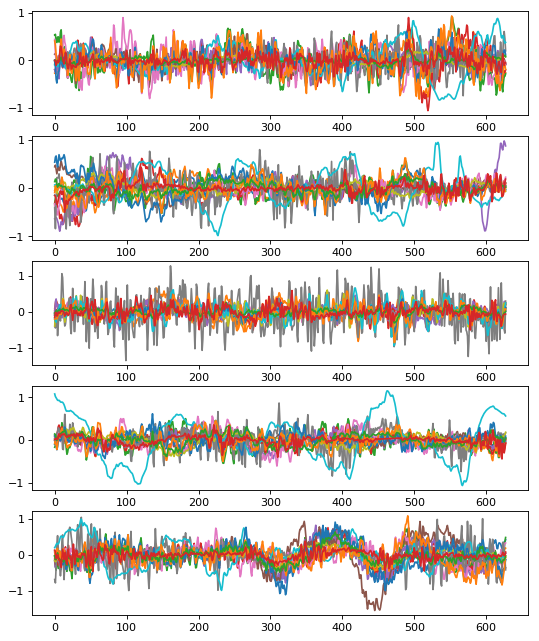

In [29]:
import os 
from random import shuffle

dataset = 3
trial = 1
path = "Data/D{:d}/final/".format(dataset)

pickleFiles = os.listdir(path)
shuffle(pickleFiles)
fig, axes = plt.subplots(5,1,figsize=(8, 10), dpi= 80)

for i in range(5):
#     print(pickleFiles[i])
    with open(path+pickleFiles[i],'rb') as fin:
        dataDict = pickle.load(fin)
#         print(dataDict['label'])
#         print(dataDict['data'].shape)
        
    for j in range(14):
        axes[i].set_title = pickleFiles[i] 
        axes[i].plot(dataDict['data'][j,:])
   
    
    
# print(len(container.dataWindowArray))

# for i in range(90):
#     win = container.dataWindowArray[i]
# #     print("idx {:02d} label {:.2f} size {:03d}".format(i, win.globalLabel, win.actualEpocSize))
    

# win = container.dataWindowArray[40]

# print(win.epocArray.shape)
# print(win.actualEpocSize)

# plt.plot(win.epocArray[:631,4])
# plt.plot(win.epocArray[:631,8])
# plt.plot(win.epocArray[:631,12])


In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

#Change Keras Input configuration
#https://keras.io/backend/#set_image_data_format

keras.backend.set_image_data_format('channels_first')

def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (1, Chans, Samples))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (1, Chans, Samples),
                                   use_bias = False)(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

In [0]:
from os.path import isfile, join
from os import listdir
import pickle


class EegDataset():

    def __init__(self,datasetPaths=["./Dataset/"],transform =None, testing=False, trainXMax=None, trainXMin=None):

        self.datasetPaths = datasetPaths
        self.files = []
        self.len = 0
        
        for datasetPath in self.datasetPaths:
            tempArr = [join(datasetPath, f) for f in listdir(datasetPath) if isfile(join(datasetPath, f))]
            self.files += tempArr
            self.len += len(tempArr)

        self.x = np.zeros((self.len, 1, 14 ,628))
        self.y = np.zeros( (len(self.files),2) )

        self.positiveLength = 0
        self.negativeLength = 0
        self.positiveIdx = []
        self.negativeIdx = []

        for i in range(len(self.files)):

            with open(self.files[i],'rb') as f1:
                dataDict = pickle.load(f1)
                self.x[i, :, :, :] = dataDict['data']
                label = int(dataDict['label'])

                if label == 1:
                    self.positiveLength += 1
                    self.positiveIdx.append(i)
                    self.y[i] = [0,1]
                elif label == 0:
                    self.negativeLength += 1
                    self.negativeIdx.append(i)
                    self.y[i] = [1,0]


        self.transform = transform


    def __getitem__(self, index):

        sample = self.x[index], self.y[index]

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return self.len


In [135]:
os.chdir("/content/RunTimeDir/")

# trainPath = ["./Data/D1/final", "./Data/D2/final", "./Data/D3/final"]
# testPath = ["./Data/D4/final"]

# trainPath = ["./Data/D4/final", "./Data/D2/final", "./Data/D3/final"]
# testPath = ["./Data/D1/final"]

# trainPath = ["./Data/D1/final", "./Data/D2/final", "./Data/D4/final"]
# testPath = ["./Data/D3/final"]

trainPath = ["./Data/D1/final", "./Data/D3/final", "./Data/D4/final"]
testPath = ["./Data/D2/final"]

trainData = EegDataset(datasetPaths=trainPath)
testData = EegDataset(datasetPaths=testPath)

print(trainData.positiveLength)
print(trainData.negativeLength)
print(trainData.x.shape)
print(trainData.y.shape)


print(testData.positiveLength)
print(testData.negativeLength)
print(testData.x.shape)
print(testData.y.shape)

523
529
(1052, 1, 14, 628)
(1052, 2)
179
174
(353, 1, 14, 628)
(353, 2)


In [147]:
from keras import losses


model = EEGNet(2, Chans = 14, Samples = 628)
adam = keras.optimizers.Adam(lr=0.01)
lossFunc = keras.losses.binary_crossentropy

model.compile(adam, loss=lossFunc, metrics=['accuracy'])
model.fit(x=trainData.x, y=trainData.y, batch_size=100, epochs=160, verbose=1)

Epoch 1/160
1052/1052 [==============================] - 1s 781us/sample - loss: 0.7161 - acc: 0.5048
Epoch 2/160
1052/1052 [==============================] - 0s 226us/sample - loss: 0.6804 - acc: 0.5798
Epoch 3/160
1052/1052 [==============================] - 0s 222us/sample - loss: 0.6542 - acc: 0.6093
Epoch 4/160
1052/1052 [==============================] - 0s 219us/sample - loss: 0.6304 - acc: 0.6378
Epoch 5/160
1052/1052 [==============================] - 0s 235us/sample - loss: 0.6284 - acc: 0.6416
Epoch 6/160
1052/1052 [==============================] - 0s 219us/sample - loss: 0.6051 - acc: 0.6806
Epoch 7/160
1052/1052 [==============================] - 0s 218us/sample - loss: 0.5139 - acc: 0.7643
Epoch 8/160
1052/1052 [==============================] - 0s 222us/sample - loss: 0.4883 - acc: 0.7842
Epoch 9/160
1052/1052 [==============================] - 0s 229us/sample - loss: 0.4855 - acc: 0.7785
Epoch 10/160
1052/1052 [==============================] - 0s 222us/sample - loss: 

In [148]:
preds = model.evaluate(x = testData.x, y = testData.y)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

353/353 [==============================] - 0s 917us/sample - loss: 0.5572 - acc: 0.7507

Loss = 0.5572376746800398
Test Accuracy = 0.7507082


In [102]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 1, 14, 628)]      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 14, 628)        512       
_________________________________________________________________
batch_normalization_16 (Batc (None, 8, 14, 628)        32        
_________________________________________________________________
depthwise_conv2d_10 (Depthwi (None, 16, 1, 628)        224       
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 1, 628)        64        
_________________________________________________________________
activation_6 (Activation)    (None, 16, 1, 628)        0         
_________________________________________________________________
average_pooling2d_6 (Average (None, 16, 1, 157)        0   

In [77]:


#!cp /root/.keras/keras.json /root/.keras/keras_copy.json

# !ls /root/.keras -ltra
# !mkdir /content/.keras/
# !cp /content/keras.json /content/.keras/ 
# !cat /root/.keras/keras.json

# !ls /content/.keras/
# !cat /content/.keras/keras.json

# !ls /home/ -ltra

# keras.backend.set_image_data_format('channels_first')
# print(keras.backend.image_data_format())


channels_first
